# Image slicer spot simulation (v03)
*A. Bolton, 2024 Jan/Feb*

*This notebook implements an initial model for an image slicer of a particular type. Just one slice right now, plus the various intermediate planes after it. Can tip/tilt PSF around to create more complex simulations.*

Release notes for v03:
 - Code is somewhat more sensible now
   - specification of parameters and geometries has been made more systematic
 - Orientation of x and y swapped relative to v02 to match the x/y convention in Tim's ppt
   - *tips* are now *tilts*; apologies for any downstream inconvenience!
 - Added support for different samplings (fine, coarse, very coarse)
 - Added support for anamorphism EXCEPT for at-detector sampling
   - *detector sampling is correct in the spectral direction but would need to be rescaled in the direction along the slit*
   - input beam anamorphism not included in oct23 models
   - input beam anamorphism yes included in feb24 models
   - spectrograph limiting aperture is currently only implemented as rectangle. Will need to implement elliptical apertures to model circle+anamorph.

In [1]:
# Imports:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import skimage.measure
import pandas as pd
from copy import deepcopy

In [2]:
# Parameters for O-2/oct23, fine:
par_dict_fine = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 159.,
    'input_fratio_y': 159.,
    'slicer_width_x': 5.4e-3*u.m,
    'slicer_width_y': 0.1e-3*u.m,
    'pupil_beam_x': 0.64e-3*u.m,
    'pupil_beam_y': 0.64e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 3.e-3*u.m,
    'pseudoslit_fratio_x': 56.83, # from 159. * 1.93 / 5.4
    'pseudoslit_fratio_y': 57.24, # from 159. * 0.036 / 0.1
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 40.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_mirror_y': 50.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_x': 10.6e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_y': 14.8e-3*u.m, # reckoned from figure in Tim's ppt
    'detector_fratio_x': 32.1, # from 159. * 1.09 / 5.4
    'detector_fratio_y': 41.3} # from 159. * 0.026 / 0.1

# Parameters for O-2/oct23, coarse:
par_dict_coarse = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 159.,
    'input_fratio_y': 159.,
    'slicer_width_x': 10.8e-3*u.m,
    'slicer_width_y': 0.2e-3*u.m,
    'pupil_beam_x': 0.64e-3*u.m,
    'pupil_beam_y': 0.64e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 3.e-3*u.m,
    'pseudoslit_fratio_x': 56.83, # from 159. * 1.93 / 10.8
    'pseudoslit_fratio_y': 58.83, # from 159. * 0.037 / 0.2
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 40.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_mirror_y': 50.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_x': 20.7e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_y': 24.6e-3*u.m, # reckoned from figure in Tim's ppt
    'detector_fratio_x': 16.3, # from 159. * 1.11 / 10.8
    'detector_fratio_y': 22.3} # from 159. * 0.028 / 0.2

# Parameters for O-2/oct23, very coarse:
par_dict_vcoarse = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 159.,
    'input_fratio_y': 159.,
    'slicer_width_x': 10.8e-3*u.m,
    'slicer_width_y': 0.4e-3*u.m,
    'pupil_beam_x': 0.64e-3*u.m,
    'pupil_beam_y': 0.64e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 3.e-3*u.m,
    'pseudoslit_fratio_x': 56.83, # from 159. * 1.93 / 10.8
    'pseudoslit_fratio_y': 58.83, # from 159. * 0.077 / 0.4
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 40.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_mirror_y': 50.e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_x': 21.3e-3*u.m, # reckoned from figure in Tim's ppt
    'spectro_beam_y': 26.9e-3*u.m, # reckoned from figure in Tim's ppt
    'detector_fratio_x': 16.6, # from 159. * 1.13 / 10.8
    'detector_fratio_y': 25.4} # from 159. * 0.064 / 0.4

# Parameters for O-2/feb24, fine:
par_dict_fine_v3 = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 80.,
    'input_fratio_y': 160.,
    'slicer_width_x': 5.8e-3*u.m,
    'slicer_width_y': 0.1e-3*u.m,
    'pupil_beam_x': 1.6e-3*u.m,
    'pupil_beam_y': 0.8e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 4.6e-3*u.m,
    'pseudoslit_fratio_x': 28.8, # from 80. * 0.36
    'pseudoslit_fratio_y': 56.0, # from 160. * 0.35
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 38.e-3*u.m, # NOTE: implemented as square but it is really circle;
    'spectro_mirror_y': 38.e-3*u.m, # NOTE: see comments in code below about needing ellipse
    'spectro_beam_x': 17.0e-3*u.m,
    'spectro_beam_y': 8.5e-3*u.m,
    'detector_fratio_x': 14.4, # from 80. * 0.36 * 0.50
    'detector_fratio_y': 32.5} # from 160. * 0.35 * 0.58

# Parameters for O-2/feb24, coarse:
par_dict_coarse_v3 = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 80.,
    'input_fratio_y': 160.,
    'slicer_width_x': 11.2e-3*u.m,
    'slicer_width_y': 0.2e-3*u.m,
    'pupil_beam_x': 1.4e-3*u.m,
    'pupil_beam_y': 0.7e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 4.6e-3*u.m,
    'pseudoslit_fratio_x': 14.4, # from 80. * 0.18
    'pseudoslit_fratio_y': 28.8, # from 160. * 0.18
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 38.e-3*u.m, # NOTE: implemented as square but it is really circle;
    'spectro_mirror_y': 38.e-3*u.m, # NOTE: see comments in code below about needing ellipse
    'spectro_beam_x': 34.0e-3*u.m,
    'spectro_beam_y': 18.5e-3*u.m,
    'detector_fratio_x': 7.5, # from 80. * 0.18 * 0.52
    'detector_fratio_y': 26.8} # from 160. * 0.18 * 0.93

# Parameters for O-2/feb24, very coarse:
par_dict_vcoarse_v3 = {
    'diam': 6.5*u.m,
    'sec_rad': 0.65*u.m,
    'n_supp': 3,
    'supp_wid': 0.15*u.m,
    'input_fratio_x': 80.,
    'input_fratio_y': 160.,
    'slicer_width_x': 11.2e-3*u.m,
    'slicer_width_y': 0.4e-3*u.m,
    'pupil_beam_x': 1.5e-3*u.m,
    'pupil_beam_y': 0.9e-3*u.m,
    'pupil_mirror_x': 2.e-3*u.m,
    'pupil_mirror_y': 4.6e-3*u.m,
    'pseudoslit_fratio_x': 14.4, # from 80. * 0.18
    'pseudoslit_fratio_y': 28.8, # from 160. * 0.18
    'pseudoslit_mirror_x': 2.e-3*u.m,
    'pseudoslit_mirror_y': 1.e-3*u.m,
    'spectro_mirror_x': 38.e-3*u.m, # NOTE: implemented as square but it is really circle;
    'spectro_mirror_y': 38.e-3*u.m, # NOTE: see comments in code below about needing ellipse
    'spectro_beam_x': 33.0e-3*u.m,
    'spectro_beam_y': 14.0e-3*u.m,
    'detector_fratio_x': 7.5, # from 80. * 0.18 * 0.52
    'detector_fratio_y': 27.1} # from 160. * 0.18 * 0.94

In [3]:
# Function to create the slicer optical system:

def make_slicer_sys(par_dict,  
                    npix = 2048,                  # number of pixels across (buffered) beam
                    pupil_factor = 10,            # beam diameter as multiple of pupil diameter (for unresolved pupil handling)
                    pix_size = 1.e-6*u.m,         # desired physical size of pixels on the detector
                    fov_pixels = 1500):           # desired FOV in pixels for detector

    # For convenience:
    diam = par_dict['diam']
    rad2arcs = 206265.
    
    # Computed parameters related to plate scales:
    pupil_diam = pupil_factor * diam         # full beam diameter
    input_flength_x = diam * par_dict['input_fratio_x']   # telescope effective focal length in x
    input_flength_y = diam * par_dict['input_fratio_y']   # telescope effective focal length in y
    input_arcsec_scale_x = input_flength_x / rad2arcs   # scale of one arcsec at input to slicer in x
    input_arcsec_scale_y = input_flength_y / rad2arcs   # scale of one arcsec at input to slicer in y
    slicer_arcsec_x = par_dict['slicer_width_x'] / input_arcsec_scale_x  # slicer dimension in arcsec in x
    slicer_arcsec_y = par_dict['slicer_width_y'] / input_arcsec_scale_y  # slicer dimension in arcsec in x
    pseudoslit_flength_x = diam * par_dict['pseudoslit_fratio_x']   # pseudoslit effective focal length in x
    pseudoslit_flength_y = diam * par_dict['pseudoslit_fratio_y']   # pseudoslit effective focal length in y
    pseudoslit_arcsec_scale_x = pseudoslit_flength_x / rad2arcs # size of one arcsec at pseudoslit in x
    pseudoslit_arcsec_scale_y = pseudoslit_flength_y / rad2arcs # size of one arcsec at pseudoslit in y
    pseudoslit_arcsec_x = par_dict['pseudoslit_mirror_x'] / pseudoslit_arcsec_scale_x # p.slit dim. in arcsec in x
    pseudoslit_arcsec_y = par_dict['pseudoslit_mirror_y'] / pseudoslit_arcsec_scale_y # p.slit dim. in arcsec in y
    detector_flength_x = diam * par_dict['detector_fratio_x']   # effective focal length in x at detector
    detector_flength_y = diam * par_dict['detector_fratio_y']   # effective focal length in y at detector
    detector_arcsec_scale_x = detector_flength_x / rad2arcs # size of one arcsec at detector in x
    detector_arcsec_scale_y = detector_flength_y / rad2arcs # size of one arcsec at detector in y
    det_pscale = (u.arcsec/u.pixel)*pix_size/detector_arcsec_scale_y # detector plate scale CORRECT FOR Y
    
    # Computed parameters related to pupils & apertures:
    pmirror_rel_x = par_dict['pupil_mirror_x'] / par_dict['pupil_beam_x']
    pmirror_rel_y = par_dict['pupil_mirror_y'] / par_dict['pupil_beam_y']
    smirror_rel_x = par_dict['spectro_mirror_x'] / par_dict['spectro_beam_x']
    smirror_rel_y = par_dict['spectro_mirror_y'] / par_dict['spectro_beam_y']

    # Hardwired parameter:
    oversample = 1    # Oversampling of Fourier modes: force to 1 to avoid confusion.
                      # (We are already buffering around the pupil explicitly.)
    
    # Append all these to a copy of the argument dictionary for reference:
    par_dict_new = deepcopy(par_dict)
    par_dict_new['npix'] = npix
    par_dict_new['pupil_factor'] = pupil_factor
    par_dict_new['pix_size'] = pix_size
    par_dict_new['fov_pixels'] = fov_pixels
    par_dict_new['_pupil_diam'] = pupil_diam
    par_dict_new['_input_flength_x'] = input_flength_x
    par_dict_new['_input_flength_y'] = input_flength_y
    par_dict_new['_input_arcsec_scale_x'] = input_arcsec_scale_x
    par_dict_new['_input_arcsec_scale_y'] = input_arcsec_scale_y
    par_dict_new['_slicer_arcsec_x'] = slicer_arcsec_x
    par_dict_new['_slicer_arcsec_y'] = slicer_arcsec_y
    par_dict_new['_pseudoslit_flength_x'] = pseudoslit_flength_x
    par_dict_new['_pseudoslit_flength_y'] = pseudoslit_flength_y
    par_dict_new['_pseudoslit_arcsec_scale_x'] = pseudoslit_arcsec_scale_x
    par_dict_new['_pseudoslit_arcsec_scale_y'] = pseudoslit_arcsec_scale_y
    par_dict_new['_pseudoslit_arcsec_x'] = pseudoslit_arcsec_x
    par_dict_new['_pseudoslit_arcsec_y'] = pseudoslit_arcsec_y
    par_dict_new['_detector_flength_x'] = detector_flength_x
    par_dict_new['_detector_flength_y'] = detector_flength_y
    par_dict_new['_detector_arcsec_scale_x'] = detector_arcsec_scale_x
    par_dict_new['_detector_arcsec_scale_y'] = detector_arcsec_scale_y
    par_dict_new['_det_pscale'] = det_pscale
    par_dict_new['_pmirror_rel_x'] = pmirror_rel_x
    par_dict_new['_pmirror_rel_y'] = pmirror_rel_y
    par_dict_new['_smirror_rel_x'] = smirror_rel_x
    par_dict_new['_smirror_rel_y'] = smirror_rel_y
    
    # Create optical system...

    # Telescope:
    osys = poppy.OpticalSystem(pupil_diameter=pupil_diam,
                               npix=npix,
                               oversample=oversample)
    prim_ap = poppy.CircularAperture(radius=diam/2.)
    ttstage = poppy.TipTiltStage(prim_ap,
                                 radius=diam/2.)
    osys.add_pupil(ttstage, name='Primary aperture')
    osys.planes[-1].wavefront_display_hint = 'intensity'
    osys.add_pupil(poppy.SecondaryObscuration(secondary_radius=par_dict['sec_rad'],
                                              n_supports=par_dict['n_supp'],
                                              support_width=par_dict['supp_wid']))
    osys.planes[-1].wavefront_display_hint = 'intensity'

    # Slicer:
    osys.add_image(poppy.ScalarTransmission(planetype=PlaneType.image,
                                            name='Telescope focal plane'))
    osys.add_image(poppy.RectangularFieldStop(width=slicer_arcsec_x*u.arcsec,
                                              height=slicer_arcsec_y*u.arcsec,
                                              name='Slicer aperture'))

    # Pupil mirror:
    osys.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil,
                                            name='Post-slicer pupil plane'))
    osys.add_pupil(poppy.RectangleAperture(width=pmirror_rel_x*diam,
                                           height=pmirror_rel_y*diam,
                                           name='Pupil mirror aperture'))
    osys.planes[-1].wavefront_display_hint = 'intensity'

    # Pseudoslit:
    osys.add_image(poppy.ScalarTransmission(planetype=PlaneType.image,
                                            name='Pseudoslit plane'))
    osys.add_image(poppy.RectangularFieldStop(width=pseudoslit_arcsec_x*u.arcsec,
                                              height=pseudoslit_arcsec_y*u.arcsec,
                                              name='Pseudoslit mirror aperture'))

    # Spectrograph:
    # (circular aperture not enabled b/c we'd have to implement an elliptical
    #  aperture to capture the anamorphism and poppy doesn't have that on tap...)
    osys.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil,
                                            name='Spectrograph pupil(ish) plane'))
    osys.add_pupil(poppy.RectangleAperture(width=smirror_rel_x*diam,
                                           height=smirror_rel_y*diam,
                                           name='Spectrograph aperture'))
    osys.planes[-1].wavefront_display_hint = 'intensity'

#    # Vestigial code block; consult this if re-implementing selectable spectro aperture shapes.
#    # note that variable names have not been updated from earlier version!!
#    if (specap_shape == 'square'):
#        osys.add_pupil(poppy.SquareAperture(size=diam*spec_pupil_factor, name='Spectrograph aperture'))
#        osys.planes[-1].wavefront_display_hint = 'intensity'
#    elif (specap_shape == 'circle'):
#        osys.add_pupil(poppy.CircularAperture(radius=0.5*diam*spec_pupil_factor, name='Spectrograph aperture'))
#        osys.planes[-1].wavefront_display_hint = 'intensity'
#    else:
#        print('Unknown value for specap_shape')

    # Detector:
    osys.add_detector(pixelscale=det_pscale, fov_pixels=fov_pixels)

    # Attach parameter dictionary:
    osys.par_dict = par_dict_new

    return osys

In [4]:
osys = make_slicer_sys(par_dict_fine_v3)
#osys = make_slicer_sys(par_dict_coarse_v3)
#osys = make_slicer_sys(par_dict_vcoarse_v3)
#osys = make_slicer_sys(par_dict_fine)
#osys = make_slicer_sys(par_dict_coarse)
#osys = make_slicer_sys(par_dict_vcoarse)

In [5]:
tilts = (np.arange(16) / 10.) * osys.par_dict['_slicer_arcsec_y'].value * u.arcsec
ntilts = len(tilts)
tilts[0]

<Quantity 0. arcsec>

## $\lambda$ = 0.4 $\mu$m

0.0 arcsec
0.001983317307692308 arcsec
0.003966634615384616 arcsec
0.005949951923076923 arcsec
0.007933269230769232 arcsec
0.009916586538461539 arcsec
0.011899903846153847 arcsec
0.013883221153846154 arcsec
0.015866538461538463 arcsec
0.01784985576923077 arcsec
0.019833173076923078 arcsec
0.02181649038461539 arcsec
0.023799807692307693 arcsec
0.025783125000000004 arcsec
0.027766442307692308 arcsec
0.02974975961538462 arcsec


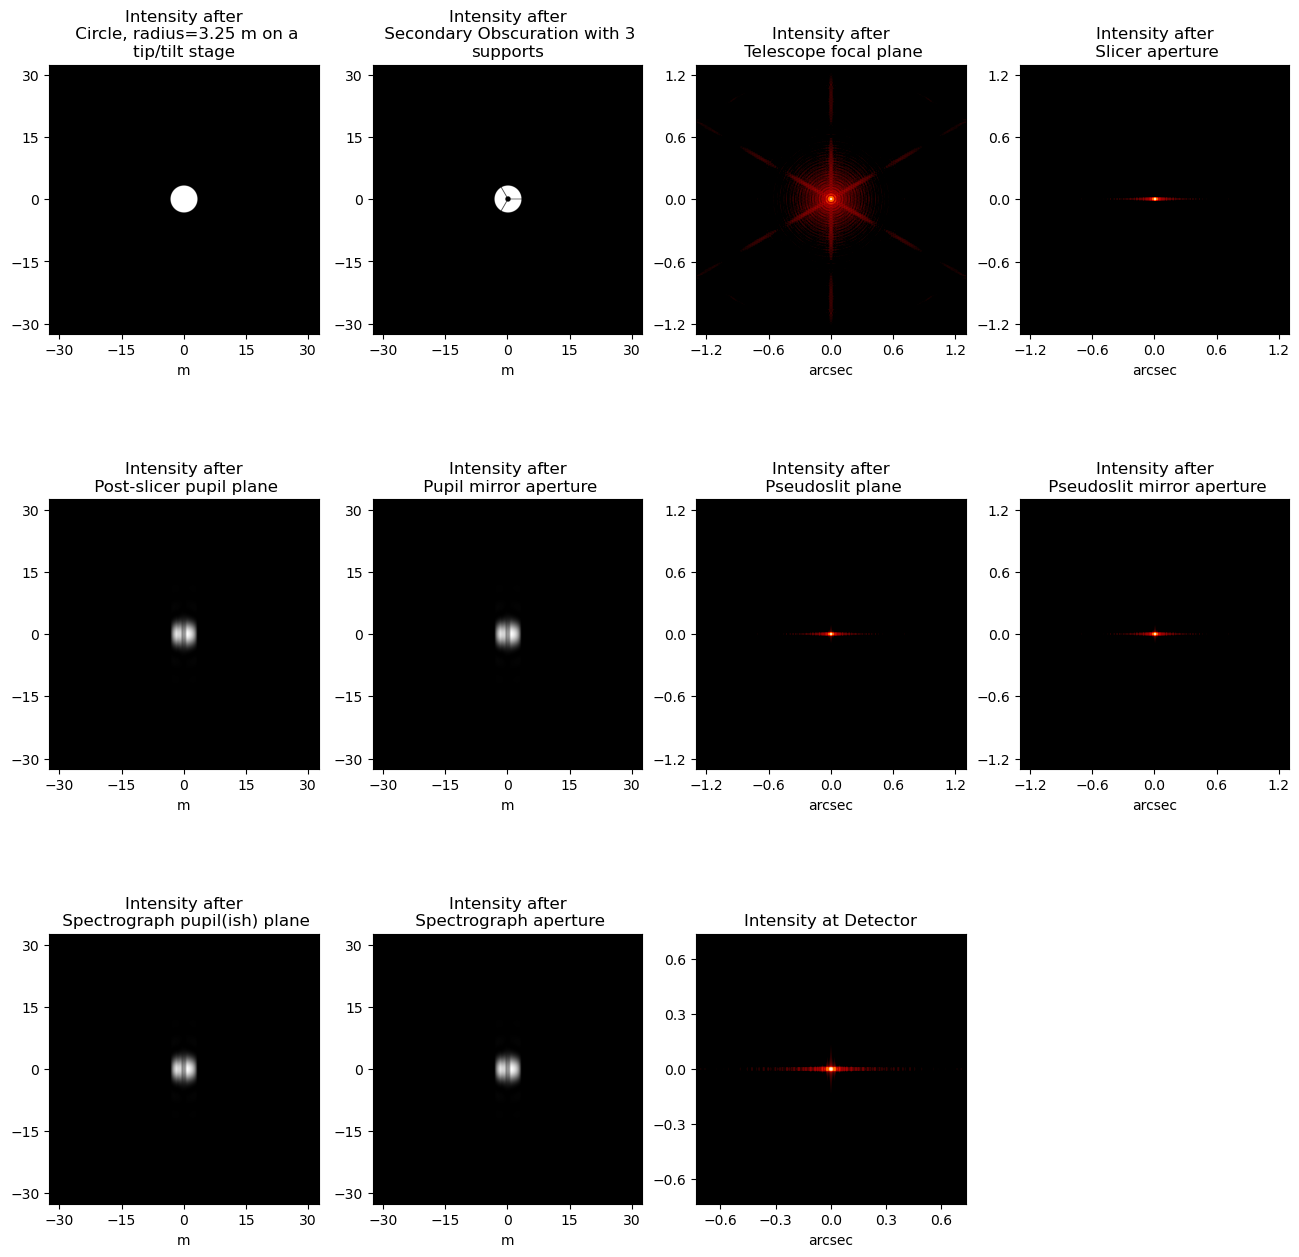

In [6]:
lam_val = 0.4*u.micron
waves_list = []
for this_tilt in tilts:
    print(this_tilt)
    osys[0].set_tip_tilt(0.,this_tilt)
    psf, waves = osys.calc_psf(wavelength=lam_val, return_intermediates=True, display_intermediates=False)
    waves_list.append(waves)
    psf = 0
    waves = 0
# To see the mosaic of intermediate planes:
plt.figure(figsize=(16,16))
osys[0].set_tip_tilt(0.,tilts[0])
junk = osys.calc_psf(wavelength=lam_val, return_intermediates=False, display_intermediates=True)
junk = 0

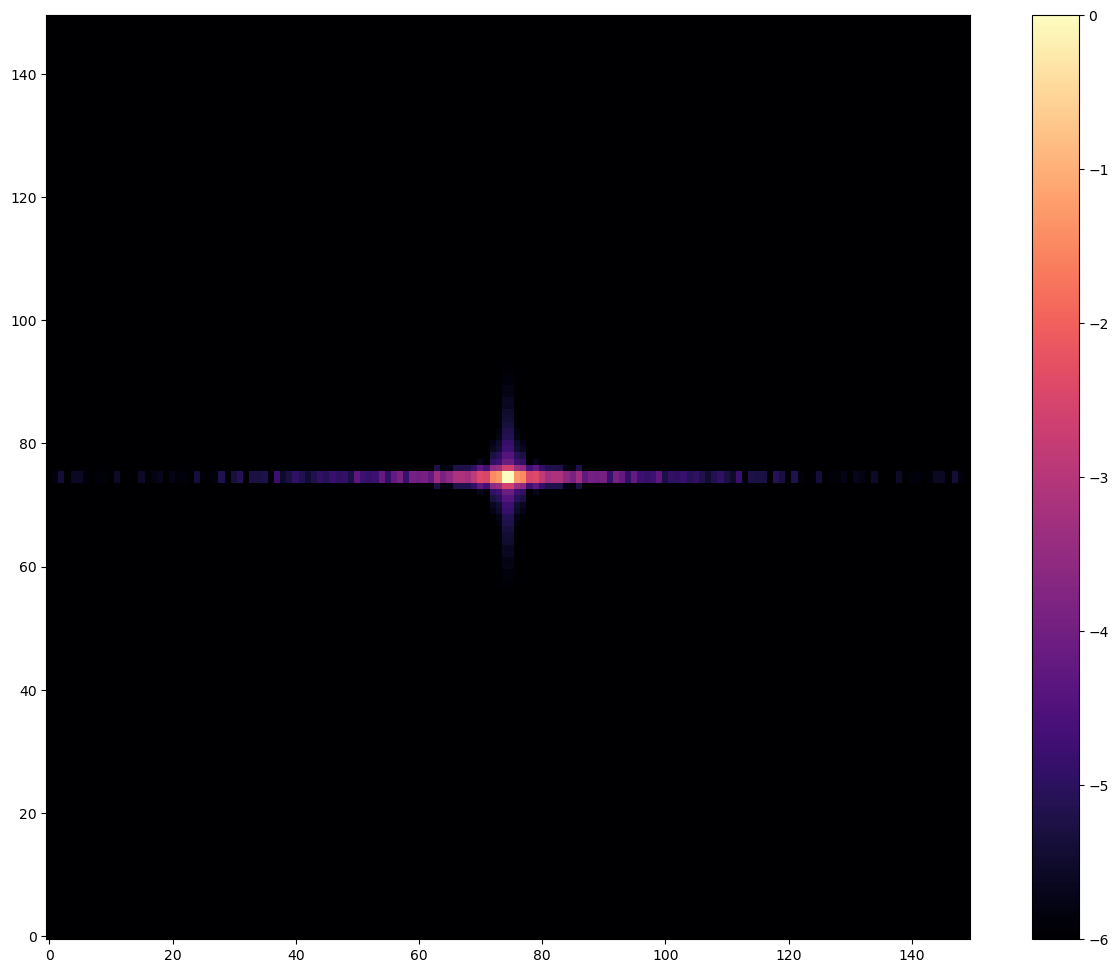

In [7]:
# Visualize pixelized slit image on detector (zero offset)
itilt = 0
plot_im = waves_list[itilt][-1].intensity
plot_im /= plot_im.max()
pix_im = skimage.measure.block_reduce(plot_im, block_size=10, func=np.sum)
pix_im /= pix_im.max()
plt.figure(figsize=(16,12))
plt.imshow(np.log10(pix_im), origin='lower', cmap='magma', interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()

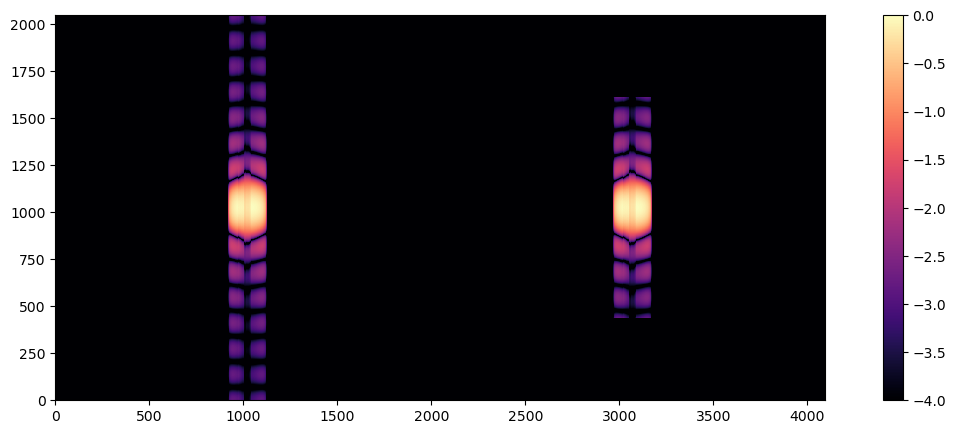

In [8]:
# Visualize loss at pupil mirror
plt.figure(figsize=(15,5))
plot_im = np.hstack([waves_list[itilt][4].intensity,waves_list[itilt][5].intensity])
plot_im /= plot_im.max()
plt.imshow(np.log10(np.maximum(plot_im,1.e-6)),
           origin='lower', cmap='magma', interpolation='nearest', vmin=-4, vmax=0)
plt.colorbar()

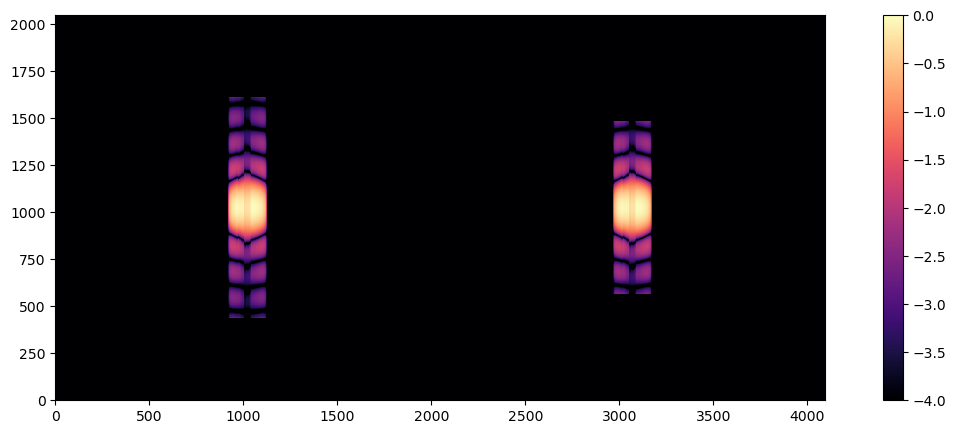

In [9]:
# Visualize loss at spectrograph pupil/prism face
plt.figure(figsize=(15,5))
plot_im = np.hstack([waves_list[itilt][8].intensity,waves_list[itilt][9].intensity])
plot_im /= plot_im.max()
plt.imshow(np.log10(np.maximum(plot_im,1.e-6)),
           origin='lower', cmap='magma', interpolation='nearest', vmin=-4, vmax=0)
plt.colorbar()

In [10]:
# Print pupil loss versus offset for 0.0, 0.5, 1.0, and 1.5 slit offsets
pupil_loss = np.asarray([1. - wave[5].intensity.sum() / wave[4].intensity.sum() for wave in waves_list])
print(pupil_loss[[0,5,10,15]])
# earlier v02 "fine" values: [0.00692943 0.03716494 0.03040321 0.04967405]
# earlier v03 "fine" values: [0.0069646  0.03699598 0.03169089 0.04362166]
# current v03 "fine" values: [0.00520192 0.02544702 0.02291635 0.03088242]
# earlier v03 "coarse" values: [0.00257466 0.0315472  0.02769265 0.01245655]
# current v03 "coarse" values: [0.0013814  0.01673365 0.01474547 0.00638408]
# earlier v03 "vcoarse" values: [0.00033963 0.02877602 0.00729427 0.00665884]
# current v03 "vcoarse" values: [0.00030398 0.02436217 0.00599524 0.00575951]

[0.00520192 0.02544702 0.02291635 0.03088242]


In [11]:
# Print spectrograph pupil / prism-face loss versus offset for 0.0, 0.5, 1.0, and 1.5 slit offsets
spectro_loss = np.asarray([1. - wave[9].intensity.sum() / wave[8].intensity.sum() for wave in waves_list])
print(spectro_loss[[0,5,10,15]])
# current v03 "fine" values: [0.00520192 0.02544702 0.02291635 0.03088242]
# current v03 "coarse" values: [0.00636828 0.07192491 0.06743737 0.02967953]
# current v03 "vcoarse" values: [0.000415   0.03292438 0.00850244 0.00797029]

[0.00261992 0.0132765  0.01192798 0.01612017]


## $\lambda$ = 1.0 $\mu$m

0.0 arcsec
0.001983317307692308 arcsec
0.003966634615384616 arcsec
0.005949951923076923 arcsec
0.007933269230769232 arcsec
0.009916586538461539 arcsec
0.011899903846153847 arcsec
0.013883221153846154 arcsec
0.015866538461538463 arcsec
0.01784985576923077 arcsec
0.019833173076923078 arcsec
0.02181649038461539 arcsec
0.023799807692307693 arcsec
0.025783125000000004 arcsec
0.027766442307692308 arcsec
0.02974975961538462 arcsec


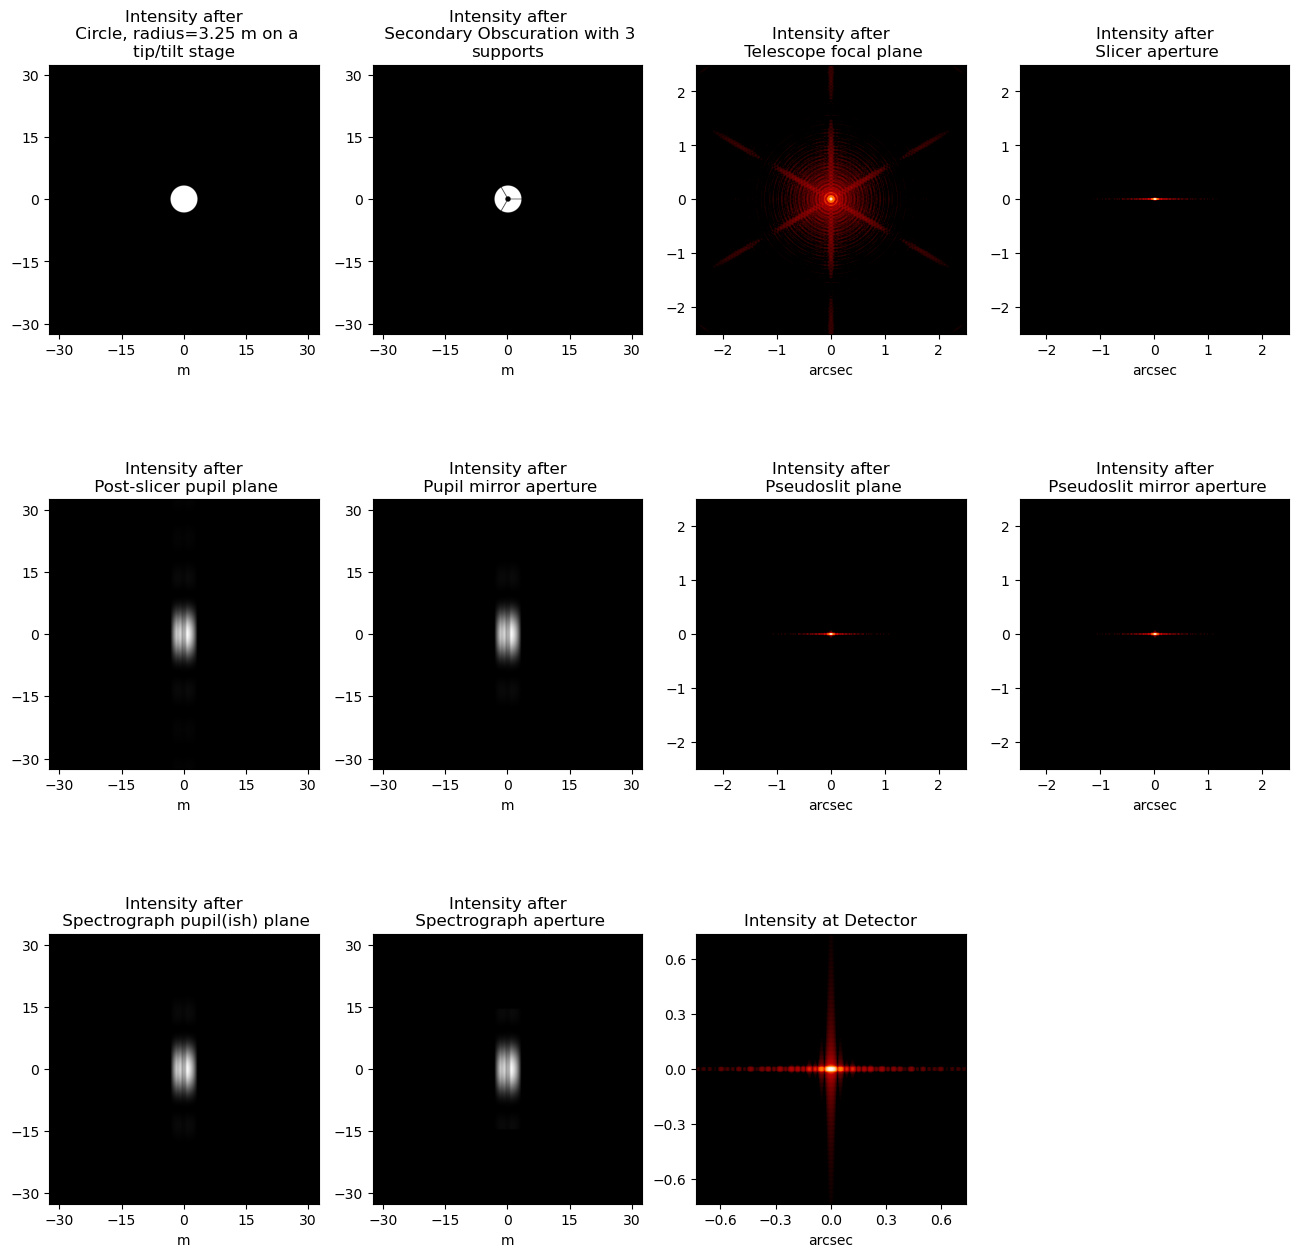

In [12]:
lam_val = 1.0*u.micron
waves_list = []
for this_tilt in tilts:
    print(this_tilt)
    osys[0].set_tip_tilt(0.,this_tilt)
    psf, waves = osys.calc_psf(wavelength=lam_val, return_intermediates=True, display_intermediates=False)
    waves_list.append(waves)
    psf = 0
    waves = 0
# To see the mosaic of intermediate planes:
plt.figure(figsize=(16,16))
osys[0].set_tip_tilt(0,tilts[0])
junk = osys.calc_psf(wavelength=lam_val, return_intermediates=False, display_intermediates=True)
junk = 0

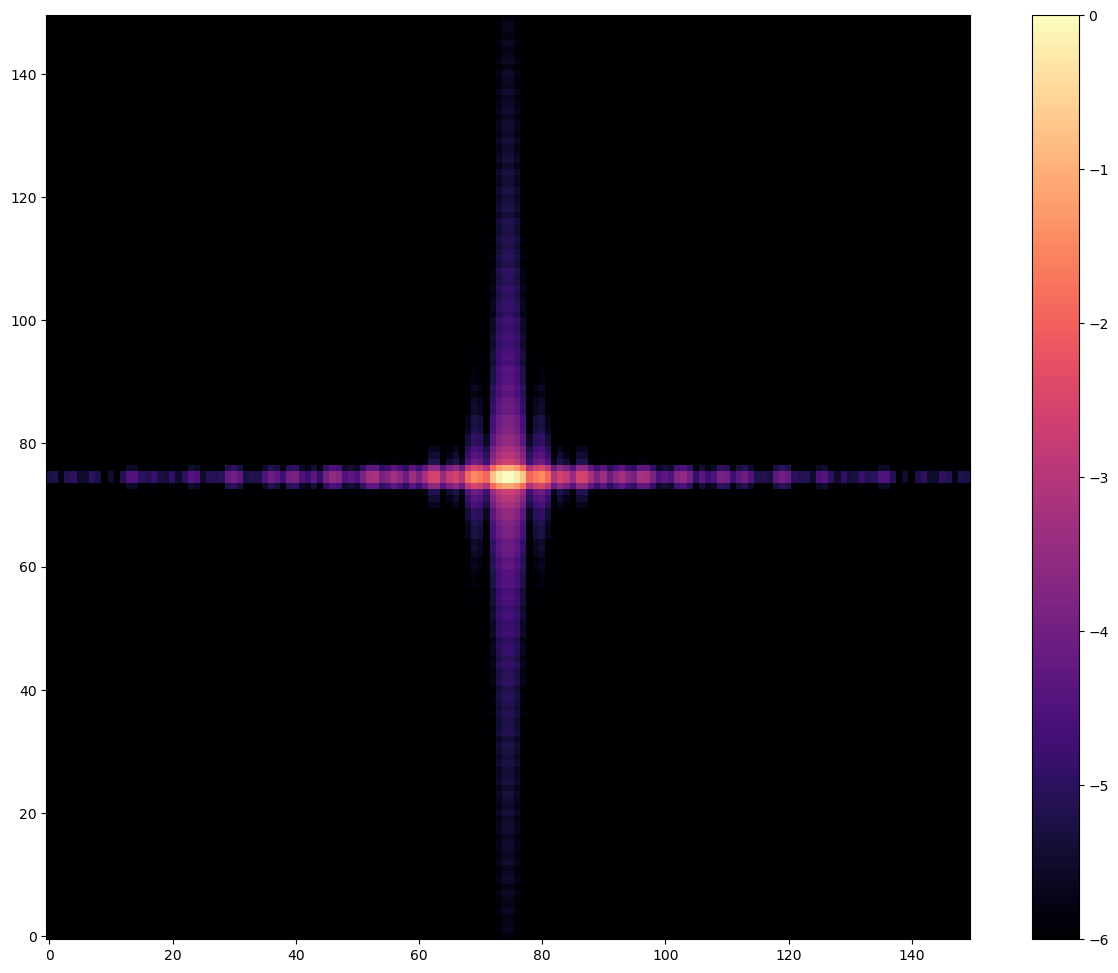

In [13]:
# Visualize pixelized slit image on detector (zero offset)
itilt = 0
plot_im = waves_list[itilt][-1].intensity
plot_im /= plot_im.max()
pix_im = skimage.measure.block_reduce(plot_im, block_size=10, func=np.sum)
pix_im /= pix_im.max()
plt.figure(figsize=(16,12))
plt.imshow(np.log10(pix_im), origin='lower', cmap='magma', interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()

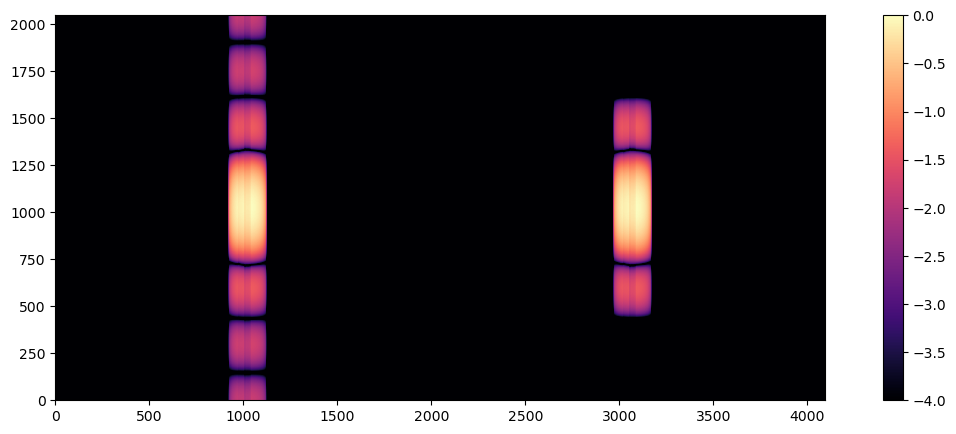

In [14]:
# Visualize loss at pupil mirror
plt.figure(figsize=(15,5))
plot_im = np.hstack([waves_list[itilt][4].intensity,waves_list[itilt][5].intensity])
plot_im /= plot_im.max()
plt.imshow(np.log10(np.maximum(plot_im,1.e-6)),
           origin='lower', cmap='magma', interpolation='nearest', vmin=-4, vmax=0)
plt.colorbar()

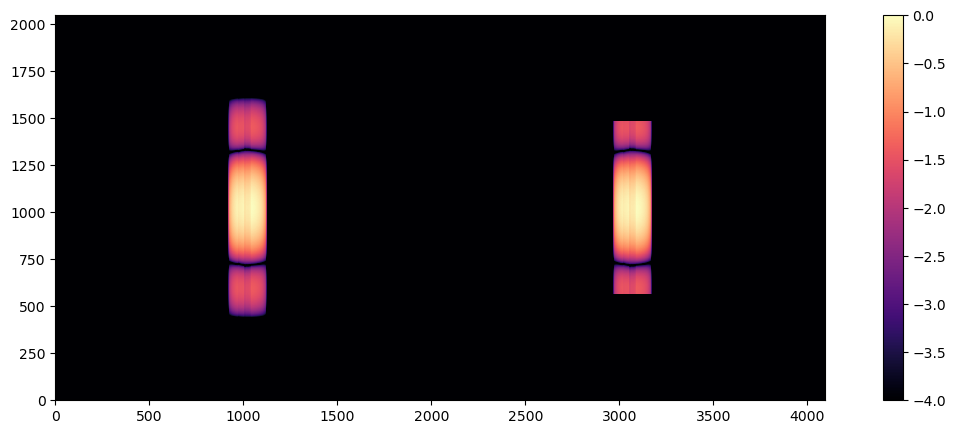

In [15]:
# Visualize loss at spectrograph pupil/prism face
plt.figure(figsize=(15,5))
plot_im = np.hstack([waves_list[itilt][8].intensity,waves_list[itilt][9].intensity])
plot_im /= plot_im.max()
plt.imshow(np.log10(np.maximum(plot_im,1.e-6)),
           origin='lower', cmap='magma', interpolation='nearest', vmin=-4, vmax=0)
plt.colorbar()

In [16]:
# Print pupil loss versus offset for 0.0, 0.5, 1.0, and 1.5 slit offsets
pupil_loss = np.asarray([1. - wave[5].intensity.sum() / wave[4].intensity.sum() for wave in waves_list])
print(pupil_loss[[0,5,10,15]])
# earlier v02 "fine" values: [0.03687575 0.04215177 0.06103088 0.09160077]
# earlier v03 "fine" values: [0.03687466 0.04211942 0.06071016 0.09058772]
# current v03 "fine" values: [0.02814487 0.03144742 0.04301414 0.06105096]
# earlier v03 "coarse" values: [0.01111977 0.03398661 0.05401973 0.02600045]
# current v03 "coarse" values: [0.00651127 0.01796579 0.02847289 0.01319679]
# earlier v03 "vcoarse" values: [0.00221978 0.0311758  0.02066634 0.01394303]
# current v03 "vcoarse" values: [0.00204902 0.02699525 0.01818476 0.01229357]

[0.02814487 0.03144742 0.04301414 0.06105096]


In [17]:
# Print spectrograph pupil / prism-face loss versus offset for 0.0, 0.5, 1.0, and 1.5 slit offsets
spectro_loss = np.asarray([1. - wave[9].intensity.sum() / wave[8].intensity.sum() for wave in waves_list])
print(spectro_loss[[0,5,10,15]])
# current v03 "fine" values: [0.01444906 0.01650148 0.02394366 0.03689567]
# current v03 "coarse" values: [0.02899746 0.07656944 0.12234665 0.06098805]
# current v03 "vcoarse" values: [0.00293758 0.03662362 0.02667424 0.01766019]

[0.01444906 0.01650148 0.02394366 0.03689567]


## $\lambda$ = 1.7 $\mu$m

0.0 arcsec
0.001983317307692308 arcsec
0.003966634615384616 arcsec
0.005949951923076923 arcsec
0.007933269230769232 arcsec
0.009916586538461539 arcsec
0.011899903846153847 arcsec
0.013883221153846154 arcsec
0.015866538461538463 arcsec
0.01784985576923077 arcsec
0.019833173076923078 arcsec
0.02181649038461539 arcsec
0.023799807692307693 arcsec
0.025783125000000004 arcsec
0.027766442307692308 arcsec
0.02974975961538462 arcsec


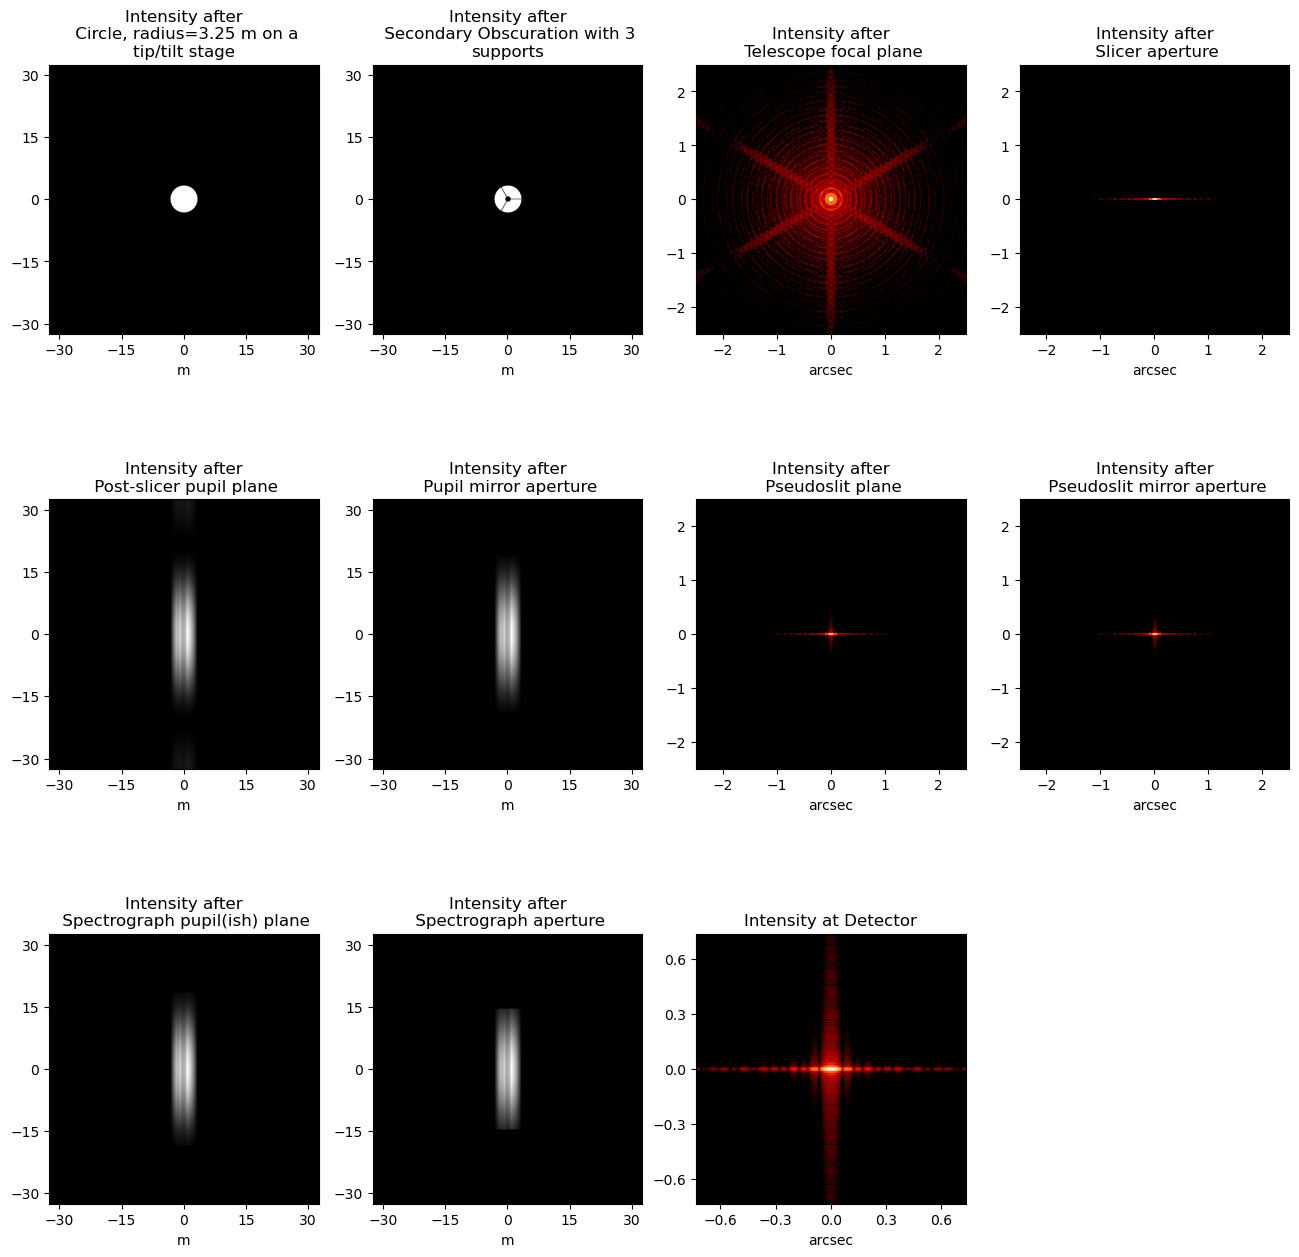

In [18]:
lam_val = 1.7*u.micron
waves_list = []
for this_tilt in tilts:
    print(this_tilt)
    osys[0].set_tip_tilt(0.,this_tilt)
    psf, waves = osys.calc_psf(wavelength=lam_val, return_intermediates=True, display_intermediates=False)
    waves_list.append(waves)
    psf = 0
    waves = 0
# To see the mosaic of intermediate planes:
plt.figure(figsize=(16,16))
osys[0].set_tip_tilt(0,tilts[0])
junk = osys.calc_psf(wavelength=lam_val, return_intermediates=False, display_intermediates=True)
junk = 0

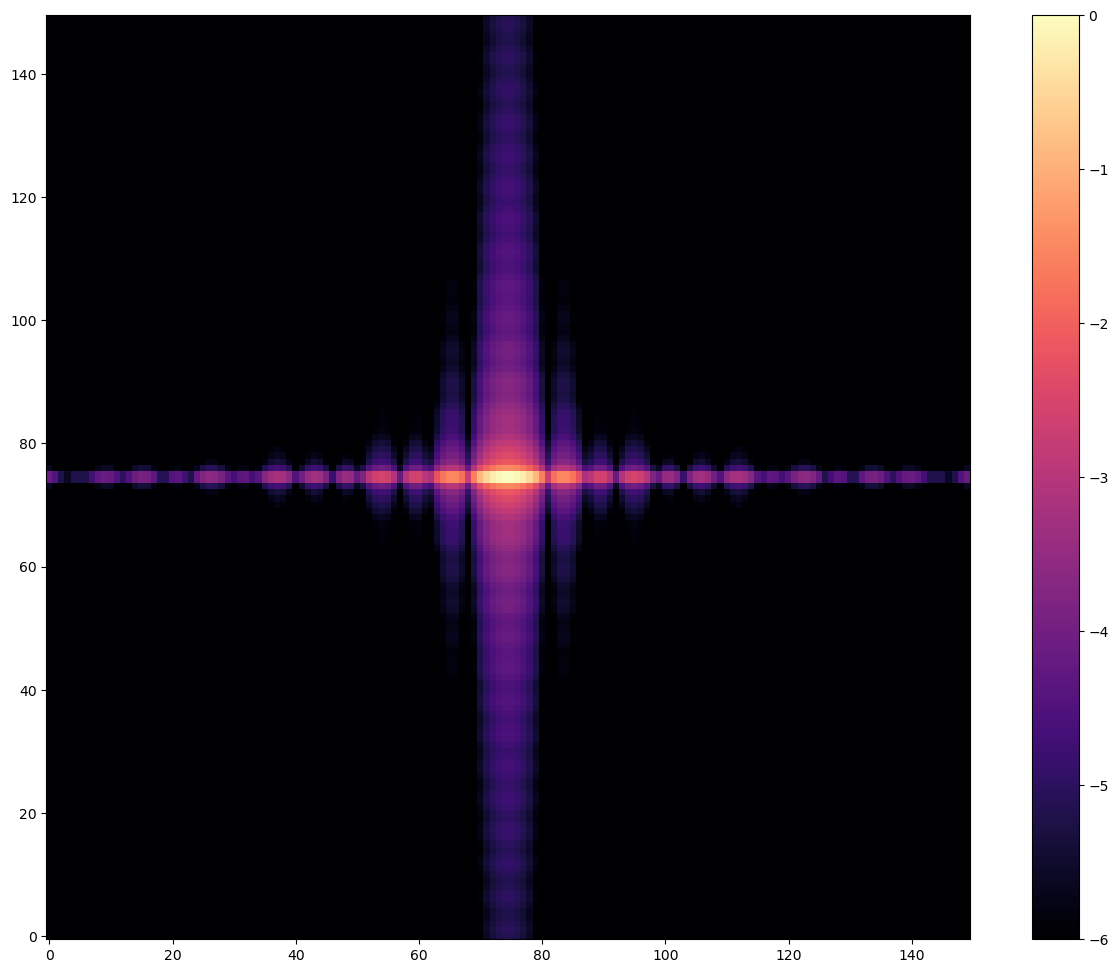

In [19]:
# Visualize pixelized slit image on detector (zero offset)
itilt = 0
plot_im = waves_list[itilt][-1].intensity
plot_im /= plot_im.max()
pix_im = skimage.measure.block_reduce(plot_im, block_size=10, func=np.sum)
pix_im /= pix_im.max()
plt.figure(figsize=(16,12))
plt.imshow(np.log10(pix_im), origin='lower', cmap='magma', interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()

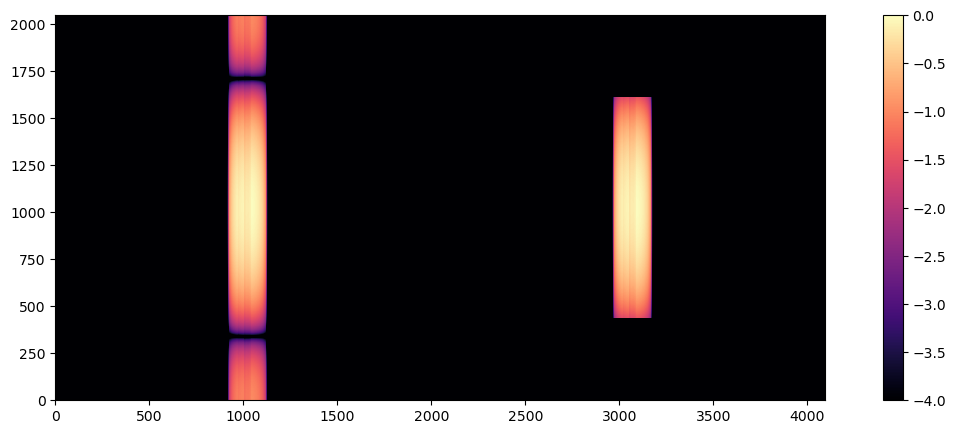

In [20]:
# Visualize loss at pupil mirror
plt.figure(figsize=(15,5))
plot_im = np.hstack([waves_list[itilt][4].intensity,waves_list[itilt][5].intensity])
plot_im /= plot_im.max()
plt.imshow(np.log10(np.maximum(plot_im,1.e-6)),
           origin='lower', cmap='magma', interpolation='nearest', vmin=-4, vmax=0)
plt.colorbar()

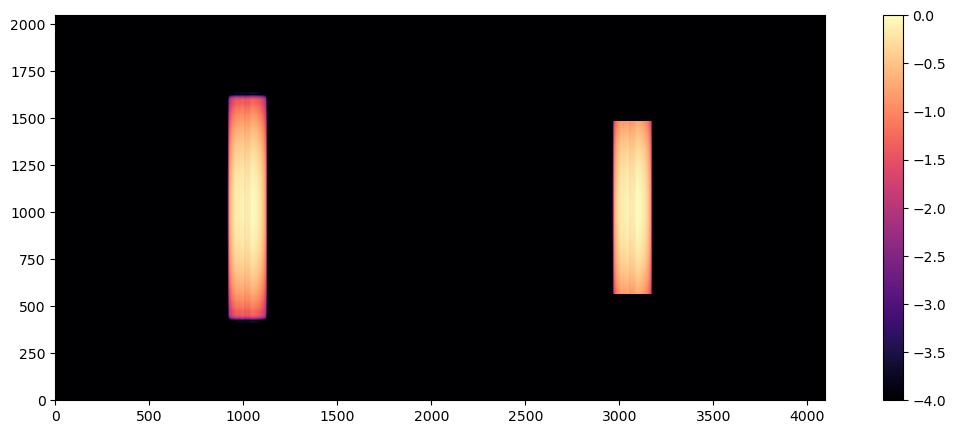

In [21]:
# Visualize loss at spectrograph pupil/prism face
plt.figure(figsize=(15,5))
plot_im = np.hstack([waves_list[itilt][8].intensity,waves_list[itilt][9].intensity])
plot_im /= plot_im.max()
plt.imshow(np.log10(np.maximum(plot_im,1.e-6)),
           origin='lower', cmap='magma', interpolation='nearest', vmin=-4, vmax=0)
plt.colorbar()

In [22]:
# Print pupil loss versus offset for 0.0, 0.5, 1.0, and 1.5 slit offsets
pupil_loss = np.asarray([1. - wave[5].intensity.sum() / wave[4].intensity.sum() for wave in waves_list])
print(pupil_loss[[0,5,10,15]])
# earlier v02 "fine" values: [0.08651341 0.08750584 0.09087142 0.09807731]
# earlier v03 "fine" values: [0.08648769 0.08747484 0.09080964 0.09788474]
# current v03 "fine" values: [0.05818654 0.05884394 0.06105261 0.0656821]
# earlier v03 "coarse" values: [0.03687464 0.04426359 0.07135089 0.08577313]
# current v03 "coarse" values: [0.02501028 0.02799637 0.03855338 0.04226549]
# earlier v03 "vcoarse" values: [0.00696228 0.03433737 0.0404745  0.0369284]
# current v03 "vcoarse" values: [0.0056174  0.03042886 0.03670504 0.03188688]

[0.05818654 0.05884394 0.06105261 0.0656821 ]


In [23]:
# Print spectrograph pupil / prism-face loss versus offset for 0.0, 0.5, 1.0, and 1.5 slit offsets
spectro_loss = np.asarray([1. - wave[9].intensity.sum() / wave[8].intensity.sum() for wave in waves_list])
print(spectro_loss[[0,5,10,15]])
# current v03 "fine" values: [0.04209825 0.04251253 0.04392426 0.04697946]
# current v03 "coarse" values: [0.07474205 0.09583604 0.17631079 0.23924811]
# current v03 "vcoarse" values: [0.00798997 0.03948854 0.05042891 0.04654507]

[0.04209825 0.04251253 0.04392426 0.04697946]
